In [1]:
%matplotlib inline
import pymc as pm
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from IPython.display import display, Markdown
az.style.use('arviz-darkgrid')
import numpy as np
np.random.seed(44)


In [2]:
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams.update({
    'figure.figsize': [8.0, 3.0],
    'figure.facecolor': '#fffff8',
    'axes.facecolor': '#fffff8',
    'figure.constrained_layout.use': True,
    'font.size': 14.0,
    'hist.bins': 'auto',
    'lines.linewidth': 3.0,
    'lines.markeredgewidth': 2.0,
    'lines.markerfacecolor': 'none',
    'lines.markersize': 8.0, 
})

# Normal Hierarchical  Models


Giorgio Corani <br/>
*Bayesian Data Analysis and Probabilistic Programming*
<br/>
<br/>
``giorgio.corani@supsi.ch``





# Based on 

* Alicia A. Johnson, Miles Q. Ott, Mine Dogucu, Bayes Rules! An Introduction to Applied Bayesian Modeling, Chapter 16,  *Hierarchical Models without Predictors*, https://www.bayesrulesbook.com/chapter-16.html


# Modeling songs popularity

* Spotify  provides a data bases of songs and their *popularity* score,  which varies over  the 0-100 scale. 


* Higher popularity usually means the song has been played often, especially  recently. 

# Research questions 


*   What’s the typical popularity of a Spotify song?


*   How does popularity vary from artist to artist?


*   For any single artist, how much does popularity vary from song to song?


*  We look for answers with a quantification of the uncertainty.

# Hierarchical data set

* The data set  comprises  one or more songs for each of the 44 artists 


* The list of artists  is a  sample from the whole population of  artists that have songs on Spotify 

<img src='img/spotify-hierarchical-data-diagram.png' width=600 align="center" >



# The structure of the data

* The $j$ subscript refers to the $j$-th  artist (we have 44 artists).

*  $n_j$: number of songs created by artist $j$.

*  $y_{ij}$:  popularity of the $i$-th song of artist $j$
    * $j \in \{1,2,…,44\}$, $i \in \{1,2,…,n_j\}$.

* The data set is constituted by  44 *sub-populations* (or *clusters*);   each artist provides a cluster of songs.

In [3]:
# the full data set is available from the bayesrule package for R. This is a reduced version which only contains song,
#author and popularity.
#The data set contains 350 songs by 44 artists
spotify = pd.read_csv("data/spotify.csv")

spotify.head()

,artist,title,popularity
0,Alok,On & On,79
1,Alok,All The Lies,56
2,Alok,Hear Me Now,75
3,Alok,The Wall,65
4,Alok,Hear Me Now,52


In [4]:
# we create a list containing the  name of each artist: ['Alok', 'Atlas Genius', 'Au/Ra', 'BUNT.', 'Beyoncé', ...]
spotify["artist"] = spotify["artist"].astype("category")
artists = list(spotify["artist"].cat.categories) 

#show the first artists
artists[0:5]

['Alok', 'Atlas Genius', 'Au/Ra', 'BUNT.', 'Beyoncé']

In [5]:
# artist_popularity contains the mean popularity of the songs of each artist and the name of the artist
# artist ranked from the less popular one.
#we drop the title
spotify = spotify[ ["artist","popularity" ]]
artist_popularity=spotify.groupby(['artist']).mean().sort_values('popularity').head()
artist_popularity

,popularity
artist,
Mia X,13.250000
Chris Goldarg,16.400000
Soul&Roll,24.200000
Honeywagon,31.666667
Röyksopp,33.250000


In [6]:
# Number of the songs of each artists; it varies between 2 and 40.
artist_count=spotify.groupby(['artist']).count()
artist_count.head()

,popularity
artist,
Alok,19
Atlas Genius,4
Au/Ra,5
BUNT.,3
Beyoncé,25


# Modelling approaches

* *Pooled*: merge  data from songs of all artists, without modelling the difference between artists.
     
     
* *Unpooled*:  independently analyzes the songs of every  artist
    * the mean popularity of songs from artist $j$ is $\mu_j$
    * inference about artists with  few published songs is  uncertain
    * cannot predict a novel artist

# Hierarchical model (a.k.a. partial pooling)

* Artist $j$ has its own  mean popularity of songs, $\mu_j$   
    
       
* Additionally, $\mu_j$ is modelled as a sample from the population of the popularity of all artists: $ \mu_j \sim N(\mu', \sigma_p)$


*  $\mu'$ and $\sigma_p$ are the mean popularity and the std deviation of the $\mu_j$'s within the *whole* population of artists (not only the 44 artists in our data set).   
    
    
* We will assign priors to $\mu'$ and $\sigma_p$.





 

# Hierarchical model (partial pooling)

* It places a prior on the parameters of the prior (*hierarchical*).
    
       
* It can make prediction also for an artist for which there are no songs in our sample, based on what it has learned about the populations of artists. Moreover, it  improves the estimates for artists with few songs. 






# Pooled model

<img src='img/spotify-density.png' width=400 align="center" >

*  We fit a  normal-normal model  on all  songs in the sample (density  shown in the plot), ignoring the grouping structure implied by the different authors.


# Pooled model

* We fit a normal-normal model on  the data set containing all songs.
\begin{align*}
\mu & \sim N(\mu', \sigma_{\mu} ) \\
\sigma & \sim \text{HalfNormal}(\xi)\\
\vec{y_{ij}} & \sim N(\mu, \sigma)
\end{align*}

*  $\mu$ and $\sigma$ are   *global* parameters, which apply to every song.

* $\mu'$ and  $\sigma_{\mu}$ are fixed numbers which are  represent some  prior knowledge.


# Prior on $\mu$

* A priori,  we assume $\mu$ to lie in  (30, 70).

* Interpreting the  interval as a region of $\pm$2 standard deviations, our prior beliefs about the mean of the population is:

$$ \mu \sim N(\underbrace{50}_{\mu'}, \underbrace{10}_{\sigma_{\mu}}) $$



# Prior on $\sigma$

In [7]:
# sigma controls the spread of popularity in the whole population of songs
# We can interpret the range (0 , 100) as a range with length 4 stds (+-2 std around the mean).
# Thus a plausible value of  sigma is  25. 
#This is slightly in excess, as some density is outside the allowed range (0,100).

# Using  scale 36, we get the median of the distribution close to 25.
from scipy.stats import halfnorm 
pd.DataFrame(halfnorm.rvs(scale=36, size=10000)).describe()

,0
count,10000.000000
mean,28.907927
std,21.774580
min,0.005977
25%,11.770519
50%,24.481657
75%,41.423314
max,137.738299


# Pooled model


\begin{align*}
\mu    & \sim N(50, 10) \\
\sigma & \sim\text{HalfNormal} (36) \\
\vec{y_{ij}}  & \sim N(\mu, \sigma) \\
\end{align*}

In [8]:
with pm.Model() as pooled_model:
    # prior
    global_mean    =  pm.Normal ('global_mean', 50,  10)
    global_sigma   =  pm.HalfNormal ('global_sigma', sigma = 36)

    #likelihood
    popularity          =  pm.Normal ('popularity', mu = global_mean,  sigma = global_sigma, observed = spotify["popularity"])
    trace_pooled     = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [global_mean, global_sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


In [9]:
# The Spotify songs have an average popularity of about 58.
# There is  a  large standard deviation  (global_sigma) of popularity  from song to song.
# The data set has large variability, as it contains songs from different authors. 
az.summary(trace_pooled)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
global_mean,58.322,1.102,56.260,60.381,0.017,0.012,4232.0,3220.0,1.0
global_sigma,20.693,0.765,19.294,22.160,0.011,0.008,4551.0,2846.0,1.0


# Quiz yourself

* How would you make  a prediction using the  pooled model for:

    * a new song of  Mia X, the artist with the lowest mean popularity  (13) in the sample? 
    * Beyoncé, the artist with the highest mean popularity (70) in the sample?
    * a group not present in the sample?
   

# Answer
* The   pooled model ignores the artist; the prediction for the popularity of a new song is the same for  every author.

* It requires computing the *predictive distribution*.

# Predicting the popularity of the next song (*predictive distribution*)

* The trace contains 4000 parameter samples  $<\mu_s, \sigma_s>$. 

* For each sample  we draw  a possible future value of popularity as:

$$
y_s^{\text{new}}  \sim \; N\left(\mu_s, \sigma_s\right)\;\; s=1,2...4000$$



# Predictive distribution for a specific artist

$$
\left[
\begin{array}{ll} 
\mu_1 &   \sigma_1 \\
\mu_2 & \sigma_2 \\
\vdots & \vdots  \\
\mu_{4000}  & \sigma_{4000} \\
\end{array}
\right]
\;\; \longrightarrow \;\;
\left[
\begin{array}{l} 
y^{\text{new}}_{1} \\
y^{\text{new}}_2 \\
\vdots \\
y^{\text{new}}_{4000} \\
\end{array}
\right]
$$

The predictive distribution accounts for:
   * uncertainty in the parameters of $\mu, \sigma$
   * uncertainty due to stochastic sampling from a normal distribution.

In [10]:
#prediction distribution of the  pooled model
post_pooled   =  az.extract(trace_pooled.posterior)

#posterior samples
mu         = post_pooled.global_mean.values
sigma      = post_pooled.global_sigma.values

y_new = np.zeros(len(mu))
for i, current_mu in enumerate(mu):
        y_new[i]   = np.random.normal (loc = mu[i], scale = sigma[i])

        

print('summary of predictive distribution: \n')
print(pd.DataFrame(y_new).describe(percentiles=[0.025, 0.975]))

summary of predictive distribution: 

                 0
count  4000.000000
mean     57.932990
std      20.607686
min     -11.614503
2.5%     17.922972
50%      57.989516
97.5%    98.192964
max     122.867050


In [11]:
#predictive distribution implemented in pymc3
#this is more convenient, but less didactic, than working  on the raw values of the trace.
with pm.Model() as pooled_model:
    # prior
    global_mean    =   pm.Normal ('global_mean', 50,  10)
    global_sigma   =  pm.HalfNormal ('global_sigma', sigma = 36)

    #likelihood
    popularity          =  pm.Normal ('popularity', mu = global_mean,  sigma = global_sigma, observed = spotify["popularity"])
    
    #prediction, computed for every posterior sample of global_mean and global_sigma.
    predictive          =  pm.Normal('predictive', mu=global_mean, sigma=global_sigma )
    trace_pooled     = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [global_mean, global_sigma, predictive]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


In [12]:
#this prediction is the same for every artist.
az.summary(trace_pooled, var_names='predictive')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
predictive,58.344,21.113,17.985,96.618,0.273,0.203,5969.0,3039.0,1.0


# Unpooled model

* It independently analyzes the songs of each artist.


* The  mean popularity of the $j$-th artist is  $\mu_j$.


* One artist’s mean doesn’t tell us anything about another’s.

# Unpooled model 

<img src='img/spotify-unpooled.png' width=500 align="center" >

* The popularity of the songs produced by artist $j$ are distributed $N(\mu_j, \sigma)$.


* We assume   $\sigma$ to be common to all artists.


      

# About the common sigma

* This  assumption of a common $\sigma$ is reasonable and simplifies the inference (we have 45 parameters rather than 88). 


* It could be  worth implementing also a  model with a different $\sigma$ for each artist and comparing the two models (model selection can be done using WAIC, a topic covered later in the course).


# Unpooled model

* The priors are the same of the pooled model. But every $\mu_j$ is now an independent parameter.

\begin{align*}
\mu_j    & \sim N(50, 10)  \; \; \; j=1,2...44\\
\sigma & \sim \text{HalfNormal}(36) \\
y_{ij}  & \sim N(\mu_j, \sigma) \\
\end{align*}

In [13]:
#to see the structure of the data
spotify

,artist,popularity
0,Alok,79
1,Alok,56
2,Alok,75
3,Alok,65
4,Alok,52
...,...,...
345,Zeds Dead,58
346,Zeds Dead,44
347,Zeds Dead,54
348,Zeds Dead,49


In [14]:
#The code below assigns a  numerical code to each author; then it assigns to each song the code of its author.
n_artist = len(artist_count) #44

#names of the authors of each song
artist       = spotify['artist'].values

#names mapped into codes
spotify['artist_code']  = spotify['artist'].astype('category').cat.codes


#how many songs from Beyoncé and BUNT.
#the item() converts the np array into a scalar.
#we will use later those two codes
beyonce_code = np.unique(spotify['artist_code'][spotify['artist']=='Beyoncé']).item()
bunt_code       = np.unique(spotify['artist_code'][spotify['artist']=='BUNT.']).item()

print('songs from Beyoncé: ', np.sum(spotify['artist'] == 'Beyoncé'));
print('songs from BUNT.: ', np.sum(spotify['artist'] == 'BUNT.'));

songs from Beyoncé:  25
songs from BUNT.:  3


In [15]:
#show the data structure
spotify

,artist,popularity,artist_code
0,Alok,79,0
1,Alok,56,0
2,Alok,75,0
3,Alok,65,0
4,Alok,52,0
...,...,...,...
345,Zeds Dead,58,43
346,Zeds Dead,44,43
347,Zeds Dead,54,43
348,Zeds Dead,49,43


# Warning - possible improvement

* To get the vector of parameters with the artist names, we could use dims=artist

* See the implementation of the unpooled model here: https://www.pymc.io/projects/examples/en/latest/case_studies/multilevel_modeling.html

* See also the code for computing the already sorted HDIs
    
    

In [16]:

with pm.Model() as unpooled_model:
    # A vector of independent means, one for each artist. Notice the keyword 'shape'.
    mu_artist            =  pm.Normal ('mu_artist', 50,  10, shape = n_artist)
    
    #The common sigma, shared among all authors.
    global_sigma    =  pm.HalfNormal ('global_sigma', sigma = 36)

    #spotify["popularity"] is the vector of popularities of each song; 
    #spotify['artist_code'] is a vector containing the code of the author of each song.
    popularity      =  pm.Normal ('popularity', mu = mu_artist[spotify['artist_code']],  sigma = global_sigma, observed = spotify["popularity"])
    
    trace_unpooled  = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_artist, global_sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


In [17]:
# posterior mean of each artist (only the first ones are shown).
#The mean is different for each artist.
# The uncertainty about the posterior mean is represented by the length of its HDI.
# Artist with many songs (like Beyoncé) have shorter HDI compared to artists with less songs(like BUNT.) 

# assing_coords is  used to assign  the artist name to each element of the vector mu_artist, and show the names in the summary.
posterior = trace_unpooled.posterior.assign_coords(mu_artist_dim_0=artists)
az.summary(posterior).head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_artist[Alok],63.395,3.090,57.864,69.199,0.036,0.025,7323.0,2891.0,1.0
mu_artist[Atlas Genius],47.140,5.773,37.099,58.038,0.061,0.045,8963.0,2940.0,1.0
mu_artist[Au/Ra],57.682,5.417,47.222,67.528,0.054,0.039,10048.0,2836.0,1.0
mu_artist[BUNT.],45.241,6.395,33.558,57.134,0.071,0.050,8202.0,2986.0,1.0
mu_artist[Beyoncé],68.293,2.770,62.823,73.473,0.027,0.019,10925.0,2434.0,1.0


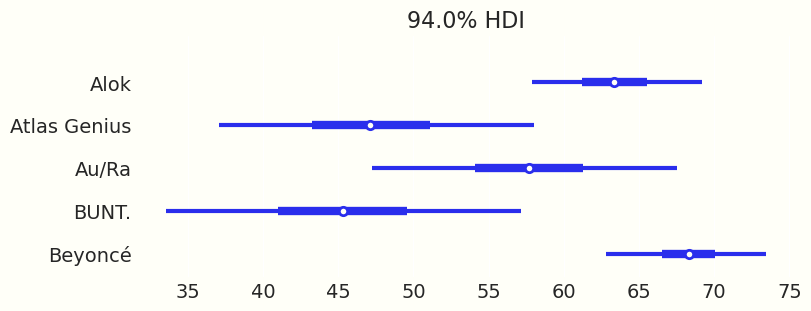

In [18]:
# The forest plot compares HDI intervals from a number of distributions  (different artists in our case).
#The HDIs are shorter for artists that have published more songs.
#We show only the first 5 artists: we limit and label the graph using the coords option. 

axes = az.plot_forest (trace_unpooled, var_names="mu_artist",
                       combined=True, # a single plot for each artist,  merging  samples from different chains.
                       coords={"mu_artist_dim_0": range(5)}, figsize=(8, 3))
artists_5 = artists[:5]
axes[0].set_yticklabels(artists_5[::-1]);

In [19]:
# the global_sigma represents the variations between songs produced by the same artist.
# It is the same for every artist.
# It is lower compared to the pooled model, as it only accounts for variations between songs of the same artists.
az.summary(trace_unpooled, var_names='global_sigma')


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
global_sigma,14.202,0.573,13.187,15.335,0.007,0.005,6571.0,3107.0,1.0


# Predictive distribution for the next song of a specific artist 

* For each  posterior samples $<\mu_{\text{Beyoncé},s}, \sigma_s>$:
    * sample $y_{\text{Beyoncé},s}^{\text{new}}$ from a normal distribution.

$$
\left[
\begin{array}{ll} 
\mu_{\text{Beyoncé},1} &   \sigma_1 \\
\mu_{\text{Beyoncé},2}  & \sigma_2 \\
\vdots & \vdots  \\
\mu_{\text{Beyoncé},4000}   & \sigma_{4000} \\
\end{array}
\right]
\;\; \longrightarrow \;\;
\left[
\begin{array}{l} 
y_{\text{Beyoncé},1}^{\text{new}} \\
y_{\text{Beyoncé},2}^{\text{new}}\\
\vdots \\
y_{\text{Beyoncé},4000}^{\text{new}}\\
\end{array}
\right]
$$

In [20]:
#predictive distribution for the next song of Beyoncé, implemented in Pymc3

with pm.Model() as unpooled_model_with_preds:
    
    #lines below as in the unpooled model 
    mu_artist         =  pm.Normal ('mu_artist', 50,  20, shape= n_artist)
    global_sigma   =  pm.HalfNormal ('global_sigma', sigma = 30)
    popularity         =  pm.Normal ('popularity', mu = mu_artist[spotify['artist_code']],  sigma = global_sigma, observed = spotify["popularity"])
    
    #predictive distribution
    pred_beyonce   = pm.Normal ('pred_beyonce', mu = mu_artist[beyonce_code],  sigma = global_sigma)
    
    trace_unpooled_with_preds  = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_artist, global_sigma, pred_beyonce]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


In [21]:
#Notice the larger uncertainty of predictive distribution, compared to the uncertainty on the posterior mean (mu_artist[Beyoncé])
#Can you explain the reason?
az.summary(trace_unpooled_with_preds, var_names=['pred_beyonce'], hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_beyonce,69.468,14.091,41.785,97.22,0.162,0.114,7646.0,2919.0,1.0


# Discussion

* Posterior mean popularity of Beyoncé: 

    * the HDI is between the .025 and .975 percentile of the posterior samples of $\mu_{\text{Beyoncé}}$
    

* Predictive distribution for the next song by Beyoncé: 

    * the HDI is between the .025 and .975 percentile of the samples $y^{\text{new}}_{\text{Beyoncé}}$, which are generated sampling from $N(\mu_{\text{Beyoncé}}, \sigma)$



# Shortcoming of the unpooled model


* estimates for artists with few songs are  uncertain

    
* it  does not model the *population* of  artists. Even though we have analyzed 44 artist, we are unable to say anything about another  Spotify artist not  present in our data set.

# Hierarchical model

\begin{equation}
\begin{array}{lrl}
& \hspace{-0.05in} y_{ij} \sim N( \mu_j, \sigma) & \hspace{-0.075in} \text{distrib of  popularity of the songs of artist } j \\
& \hspace{-0.05in} \sigma\sim HN(\xi) & \hspace{-0.075in} \text{prior on } \sigma  \\
 & \hspace{-0.05in} \mu_j \sim N( \mu', \sigma_\mu) & \hspace{-0.075in}  \text{ $\mu_j$ is a sample from the population of artists}\\
& \sigma_\mu  \sim HN(\xi_2)  & \hspace{-0.075in}
 \text{prior beliefs about std of populairity in the population} \\
& \hspace{-0.05in}  \mu' \sim N(\mu_{\text{pop}}, \sigma_{\text{pop}}) &
 \text{prior beliefs about mean popularity in the population} \\
\\
\end{array}
\end{equation}

* There is a prior over $\mu'$ and $\sigma_{\mu}$ (which are instead fixed numbers in the normal-normal model). This is a *hierarchy* of priors.

# Individual songs for each artist.

* As in the unpooled model,  the popularity of songs  of  artist $j$ are distributed:

$$  y_{ij} \sim N(\mu_j, \sigma) $$


*  $σ$ is the global sigma, which is equal for  all artists.

* $\mu_j$ is however differently estimated by the unpooled and the hierarchical model; see later.

# Population of artists



* The 44 $\mu_j$'s  are samples  from the population of Spotify artists:


$$ \mu_j \sim N(\mu', \sigma_{\mu}) $$

* $\mu'$: mean of the $\mu_j$'s in the whole population of  Spotify artists 
* $\sigma_{\mu}$: spread between the  $\mu_j$'s within the population

# Modeling the population of artists

$$ \mu_j \sim N(\mu', \sigma_{\mu}) $$


* We want to learn the population of artists.
* Both $\mu'$ and $\sigma_{\mu}$ are  *parameters*, to which we will assign a prior.

# Notation alert

*  $\mu_j$: mean popularity of songs from  the j-th artist
* $\mu'$: mean value of the $\mu_j$'s within the whole  population of artists


* $\sigma$:  standard deviation of popularity between songs from the same author. 
* $\sigma_{\mu}$ standard deviation of the $\mu_j$ within the population of artists.

# Priors for  $\mu'$ and  $\sigma_{\mu}$

\begin{align*}
\mu'           & \sim N(50, 20) && \text{95% pred interval is (50 +- 40)} \\
\sigma_{\mu} & \sim \text{Half Normal}(6)    && \text{spread between the different } \mu_j  \\
\end{align*}

In [22]:
# how to choose the priors on sigma_mu
# We assume the various mu_j  to vary in 0,100; hence a plausible sigma_mu is 15 (the HN has a long right tail anyway)
pd.DataFrame(np.abs(np.random.normal(0, scale=22, size=10000))).describe(percentiles=[0.50, 0.75, 0.95])

,0
count,10000.000000
mean,17.608110
std,13.295309
min,0.003925
50%,14.813870
75%,25.360809
95%,43.273504
max,77.488669


In [23]:
n_artist = len(artist_count) #44

with pm.Model() as hier_model:
    
    # prior on the parameters of the population of artists (hyper-priors). 
    
    # prior beliefs about the mean value and the spread of the different mu_j
    #This is where the hierarchical model differs from the unpooled model.
    mu_pop         = pm.Normal ('mu_pop', 50,  20)
    sigma_mu     = pm.HalfNormal ('sigma_mu', 22)
    
    
    # layer 2: each artist is a sample from the population of artists; we sample n_artist times from such population.
    mu_artist        =  pm.Normal ('mu_artist', mu=mu_pop, sigma=sigma_mu, shape= n_artist)
    
    # global_sigma (spread between songs of the same authors) is as in the unpooled model.
    global_sigma   =  pm.HalfNormal ('global_sigma', sigma = 30)

    #Popularity of each song is a sample from N(mu_j, global_sigma).
    popularity    =  pm.Normal ('popularity', mu = mu_artist[spotify['artist_code']],  sigma = global_sigma, observed = spotify["popularity"])
    
    trace_hier    = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_pop, sigma_mu, mu_artist, global_sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


In [24]:
#mu_pop is indeed close to 50 as we assumed
#the 95% popularity of the artists varies in roughly 52 +- 30
#the songs of a given author are comprised with 95% probability within a range of +-28 around its mean.
az.summary(trace_hier, var_names=["mu_pop", "sigma_mu", "global_sigma", "mu_artist"])[["mean","hdi_3%","hdi_97%","r_hat"]].head()

,mean,hdi_3%,hdi_97%,r_hat
mu_pop,52.383,47.955,57.308,1.0
sigma_mu,15.200,11.805,18.819,1.0
global_sigma,14.048,12.960,15.080,1.0
mu_artist[0],64.340,58.637,70.310,1.0
mu_artist[1],46.918,34.523,59.027,1.0


In [25]:
# preparing the traces, to be able to access using names. 
#this way the name of the artist is assigned to each mu_j
#the trace object has an internal field called mu_artist_dim_0
trace_unpooled.posterior = trace_unpooled.posterior.assign_coords(mu_artist_dim_0=artists)
trace_hier.posterior = trace_hier.posterior.assign_coords(mu_artist_dim_0=artists)

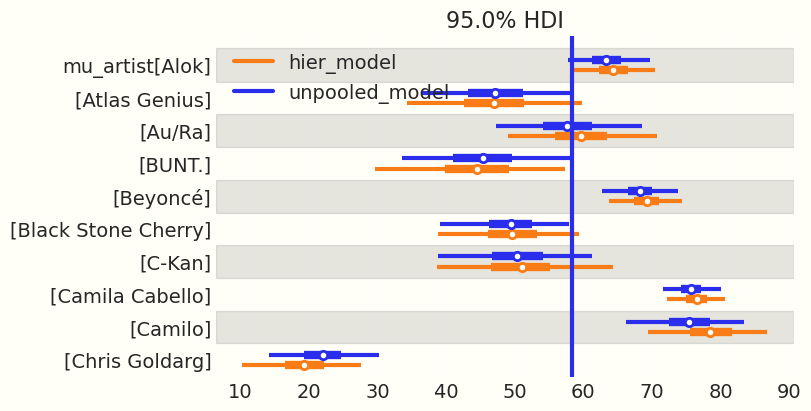

In [26]:
#estimated mean popularity of each artist, according to the unpooled and to the hierarhical model
# the expected values of the hierarchical model are pulled towards to general mean (shrinkage).
axes = az.plot_forest([trace_unpooled, trace_hier], 
                      model_names=['unpooled_model', 'hier_model'], combined=True,
                      var_names='mu_artist', hdi_prob=0.95, coords={"mu_artist_dim_0": artists[0:10]},  figsize=(8, 4));
#mean popularity of all songs
grand_mean = spotify["popularity"].mean()
axes[0].axvline(x=grand_mean);

# Shrinkage: pulling the estimates towards the grand mean

*  The pooled  model ignores the fact that our data is grouped by artist.


*  The unpooled model separately analyzes each artist ignoring the information about the grand mean.


* The hierarchical model pulls  the estimates of the unpooled model  towards the grand mean (*shrinkage*).


# Shrinkage

* Given $\sigma^2$ and  $\sigma^2_{\mu}$, the posterior mean of the hierarchical model for  artist $j$  is: 

$$
\overline{\mu}_{j,\text{hier}} =
\underbrace{
\frac{\sigma^2}{\sigma^2 + n_j \sigma^2_{\mu}}
}_{\text{weight of the grand mean}}
\overline{\mu}_{\text{pooled}} + 
\underbrace{
\frac{n_j\sigma^2_{\mu}}{\sigma^2+ n_j \sigma^2_{\mu}}
}_{\text{weight of the estimate of the unpooled model}}
\overline{\mu}_{j, \text{unpooled}}
$$

* We denote by $\overline{\mu}$ the posterior mean.

# Shrinkage

$$
\overline{\mu}_{j,\text{hier}} =
\underbrace{
\frac{\sigma^2}{\sigma^2 + n_j \sigma^2_{\mu}}
}_{\text{weight of the grand mean}}
\overline{\mu}_{\text{pooled}} + 
\underbrace{
\frac{n_j\sigma^2_{\mu}}{\sigma^2+ n_j \sigma^2_{\mu}}
}_{\text{weight of the estimate of the unpooled model}}
\overline{\mu}_{j, \text{unpooled}}
$$


* If $n_j$ is small:  $$\overline{\mu}_{j,\text{hier}}  \approx \overline{\mu}_{\text{pooled}}$$

* If $n_j$ is large:  $$\overline{\mu}_{j,\text{hier}}  \approx \overline{\mu}_{j, \text{unpooled}}$$




# Shrinkage

$$
\overline{\mu}_{j,\text{hier}} =
\underbrace{
\frac{\sigma^2}{\sigma^2 + n_j \sigma^2_{\mu}}
}_{\text{weight of the grand mean}}
\overline{\mu}_{\text{pooled}} + 
\underbrace{
\frac{n_j\sigma^2_{\mu}}{\sigma^2+ n_j \sigma^2_{\mu}}
}_{\text{weight of the estimate of the unpooled model}}
\overline{\mu}_{j, \text{unpooled}}
$$


* If $\sigma^2  \gg \sigma^2_{\mu}$: $ \overline{\mu}_{j,\text{hier}}  \approx \overline{\mu}_{\text{pooled}}$

* If $\sigma^2  \ll \sigma^2_{\mu}$:  $$ \overline{\mu}_{j,\text{hier}}  \approx \overline{\mu}_{j, \text{unpooled}}$$




# Shrinkage

* This allows  understanding *shrinkage*.


* The behavior of the model is in reality more complex as  variances and means are parameters.


* Hence a different weighted sum is computed  for each posterior sample of the trace. 

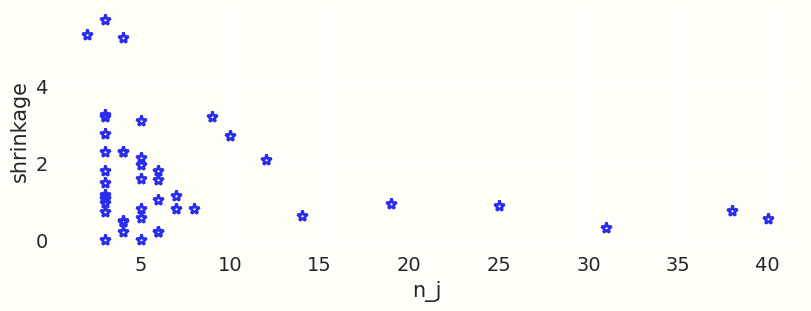

In [27]:
# here we define shrinkage as the difference between the posterior mean of the hierarchical model 
# and the unpooled model, in absolute value.
# We show that  shrinkage, in absolute value, decreases with  the number of songs that one  artist has..

n_j = spotify['artist'].value_counts(sort=False)
mean_unpooled = az.summary(trace_unpooled, var_names=["mu_artist"])["mean"]
mean_hier = az.summary(trace_hier, var_names=["mu_artist"])["mean"]

#absolute value of the shrinkage
shrinkage = pd.Series((mean_hier-mean_unpooled).values, index=artists).abs()

df = pd.concat([n_j, shrinkage], axis=1)
df.columns = ["n_j", "shrinkage"]
plt.plot(df["n_j"], df["shrinkage"], "*")
plt.xlabel("n_j")
plt.ylabel("shrinkage"); 

# Predictive distribution for the next song of a known artist

$$
\left[
\begin{array}{ll} 
\mu_{\text{Beyoncé},1} &   \sigma_1 \\
\mu_{\text{Beyoncé},2}  & \sigma_2 \\
\vdots & \vdots  \\
\mu_{\text{Beyoncé},4000}   & \sigma_{4000} \\
\end{array}
\right]
\;\; \longrightarrow \;\;
\left[
\begin{array}{l} 
y_{\text{Beyoncé},1}^{\text{new}} \\
y_{\text{Beyoncé},2}^{\text{new}}\\
\vdots \\
y_{\text{Beyoncé},4000}^{\text{new}}\\
\end{array}
\right]
$$

* This works in the same way of the unpooled model,  with the difference that the values of $\mu_{\text{Beyoncé}}$ will be (slightly) pulled towards the general mean.

# Predictive distribution for the first song artist of a new artist 

* It requires two sampling steps.


* First we sample possible values of $\mu_{\text{new a}}$ of the new artist from the population of artists.


* Given the samples of $\mu_{\text{new a}}$, we follow the same procedure of the  artists with songs.



# Predictive distribution for the first song artist of a new artist 

* We create samples for $\mu_{\text{new a}}$  by using the  posterior samples of $\mu'$ and $\sigma_{\mu}$, i.e., by sampling from the population of artists.

$$
\left[
\begin{array}{ll} 
\mu'_{,1} &   \sigma_{\mu,1} \\
\mu'_{,2}  & \sigma_{\mu,2} \\
\vdots & \vdots  \\
\mu_{',4000}   & \sigma_{\mu,4000} \\
\end{array}
\right]
\;\; \longrightarrow \;\;
\left[
\begin{array}{l} 
\mu_{\text{new a},1} \\
\mu_{\text{new a},2}\\
\vdots \\
\mu_{\text{new a},4000}\\
\end{array}
\right]
$$

# Predictive distribution for the next song of a  known artist

* For each posterior sample  $<\mu_{\text{new a},s}, \sigma_s>$, draw a value from $N(\mu_{\text{new a},s}, \sigma_s)$.

$$
\left[
\begin{array}{ll} 
\mu_{\text{new a},1} &   \sigma_1 \\
\mu_{\text{new a},2}  & \sigma_2 \\
\vdots & \vdots  \\
\mu_{\text{new a},4000}   & \sigma_{4000} \\
\end{array}
\right]
\;\; \longrightarrow \;\;
\left[
\begin{array}{l} 
y_{\text{new a},1} \\
y_{\text{new a},2}\\
\vdots \\
y_{\text{new a},4000}\\
\end{array}
\right]
$$

# Your turn

* Working on the raw samples from the trace, compute:

    * the predictive distribution for the next song of Beyonce and BUNT using  the hierarchical and the unpooled model; comment the results.

    * the predictive distribution for the first song of a a new artist using to the hierarchical model.

    * hint:  use `beyonce_code` as index  for the position Beyonce within mu_artist



# Your turn - 2

* Alicia  invites four friends to  take 20 times a  speed-typing test. Let $y_{ij}$ be the time it takes friend $j$ to complete test $i$.

* Define a hierarchical model and discuss the meaning of $μ_j$, $μ'$, $σ$, $σ_{\mu}$.
    
* Assume that each person is  consistent in his typing times, but there are big differences from person to person. 

    * Is  $ \sigma$  lower, larger or close to $\sigma_{\mu}$?


# Grouping variable or covariate?

* Consider a categorical variable  $X$.


* Should $X$  be modeled  hierarchically  or  treated as a categorical variable (unpooled model)?

    *   if the data covers all categories,  it is better treated as a categorical variable
    
    *  if the observed categories are only a  sample from many possible ones,  the hierarchical approach is recommended.


# Grouping variable or covariate?


* Our data set includes only  44 among thousands of artists on Spotify. Treating artist as a categorical variable (unpooled model) would limit our conclusions  to  this small sample.


* Treating it as a grouping variable (hierarchical model) allows us to learn about the  broader population of artists from which they were sampled.


# Grouping variable or covariate?

* A daily data set of bike-sharing covers two years;  we know whether each day  was a weekday or a weekend.

* The dataset covers both categories, with many observations for each category.

* Hence  it is better treated as a categorical variable (unpooled model).

# Grouping variable or covariate?

* Consider a data set containing math scores  from of 10  Swiss primary schools; this is a  small sample from the hundreds  of schools.


* The unpooled model  learns only about this small sample of schools.


* The hierarchical model   extends its conclusions to the  population of all schools; this is a better modelling choice.
    
    
* The same consideration applies if you want to analyze e.g. data of a certain disease collected by different hospitals.

# Solutions

In [30]:
#prediction for Beyonce using the unpooled and the hierarchical model 
post_hier         = az.extract_dataset(trace_hier.posterior)
mu_beyonce_hier   = post_hier.mu_artist[beyonce_code].values
global_sigma_hier = post_hier.global_sigma.values

post_unpooled          = az.extract(trace_unpooled.posterior)
mu_beyonce_unpooled    = post_unpooled.mu_artist[beyonce_code].values
global_sigma_unpooled  = post_unpooled.global_sigma.values

y_beyonce_hier          = np.zeros(len(mu_beyonce_hier))
y_beyonce_unpooled = np.zeros(len(mu_beyonce_hier))

for i, current_mu in enumerate(mu_beyonce_hier):
        y_beyonce_hier[i]          = np.random.normal (loc = mu_beyonce_hier[i], scale = global_sigma_hier[i])
        y_beyonce_unpooled[i] = np.random.normal (loc = mu_beyonce_unpooled[i], scale = global_sigma_unpooled[i])

#the predictions of the hierarchical model are slightly lower and pulled towards the mean of the pooled model.
#yet the difference is small since there are many songs from Beyonce. 
print('hier: ')
print(pd.DataFrame(y_beyonce_hier).describe(percentiles=[0.025, 0.975]))
print('\n\n')

print('unpooled:')
print(pd.DataFrame(y_beyonce_unpooled).describe(percentiles=[0.025, 0.975]))

hier: 
                 0
count  4000.000000
mean     69.103314
std      14.047802
min      21.990003
2.5%     40.947780
50%      69.418058
97.5%    97.514205
max     113.737763



unpooled:
                 0
count  4000.000000
mean     67.804200
std      14.104367
min      18.417092
2.5%     40.663680
50%      67.700417
97.5%    95.430343
max     120.955614


/var/folders/2k/rgs_y6s556x557660m9wmrfc0000gp/T/ipykernel_98524/251561516.py:2: FutureWarning: extract_dataset has been deprecated, please use extract
  post_hier         = az.extract_dataset(trace_hier.posterior)


In [29]:
#prediction for a novel artist
post_hier   = az.extract(trace_hier.posterior)

#posterior parameters of the population
mu_population     = post_hier.mu_pop.values
sigma_population = post_hier.sigma_mu.values

mu_new_artist  = np.zeros(len(mu_population))

for i, current_mu in enumerate(mu_population):
        mu_new_artist[i] = np.random.normal (loc = mu_population[i], scale = sigma_population[i])

#now we have the distribution for the mean of the novel artist.
#we thus compute the distribution for its next song
global_sigma = post_hier.global_sigma.values
popularity_new_song_new_artist  = np.zeros(len(global_sigma))

for i, current_mu in enumerate(mu_population):
        popularity_new_song_new_artist[i] = np.random.normal (loc = mu_new_artist[i], scale = global_sigma[i])

#we obtain a  large predictive distribution, whose 95% hdi varies between 9.8 and 94.
#there is a major increase in the std wrt a known artist such as Beyonce.
pd.DataFrame(popularity_new_song_new_artist).describe(percentiles=[0.025, 0.975])        

,0
count,4000.000000
mean,52.760462
std,20.726237
min,-26.487966
2.5%,12.107228
50%,53.146993
97.5%,93.814183
max,131.258217
